### ***                 CHỦ ĐỀ:  ỨNG DỤNG MÔ HÌNH HỌC MÁY VÀO DỰ ĐOÁN SỐ ĐIỆN SỬ DỤNG TRONG THÁNG***


# Cách sử dụng trên Google Colab:

---




**Bước 1: Cài đặt kagglehub (chạy cell đầu tiên)**

**Bước 2: Xác thực Kaggle (Ở đây dataset ta chọn electric-power-consumption-data-set là public nên không cần xác thực)**

**Bước 3: Chạy các cell theo thứ tự**


---




In [248]:
#Cài đặt và import các thư viện cần thiết
!pip install kagglehub[pandas-datasets]
# Cài đặt optuna (nếu chưa có)
!pip install optuna

# Import các thư viện cần thiết cho quá trình tối ưu
import optuna
from sklearn.linear_model import Ridge, Lasso, LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# **1. TIỀN XỬ LÝ DỮ LIỆU (PREPROCESSING)**

---


*1.1. Tải và Làm sạch dữ liệu*

---



In [249]:
# 1.1 Tải dữ liệu
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
df = pd.read_csv(f"{path}/household_power_consumption.txt", sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=False, na_values=['?'])
df.set_index('datetime', inplace=True)

# 1.2 Gom nhóm theo ngày (Resampling)
df_daily = df['Global_active_power'].resample('D').sum().to_frame()

# 1.3 Xử lý dữ liệu thiếu (Interpolation)
df_daily['Global_active_power'] = df_daily['Global_active_power'].interpolate(method='time')

# 1.4 Xử lý giá trị ngoại lai (Outlier Handling) - GIÚP GIẢM SAI SỐ
# Giới hạn giá trị ở mức phân vị 99% để loại bỏ các đỉnh nhiễu bất thường
upper_limit = df_daily['Global_active_power'].quantile(0.99)
df_daily['Global_active_power'] = df_daily['Global_active_power'].clip(upper=upper_limit)

print(f"✓ Hoàn thành tiền xử lý. Số dòng: {len(df_daily)}")

Using Colab cache for faster access to the 'electric-power-consumption-data-set' dataset.
✓ Hoàn thành tiền xử lý. Số dòng: 1442






---

**2. KHÁM PHÁ DỮ LIỆU TRỰC QUAN (EDA)**
---
2.1. Phân bổ Biến mục tiêu

---




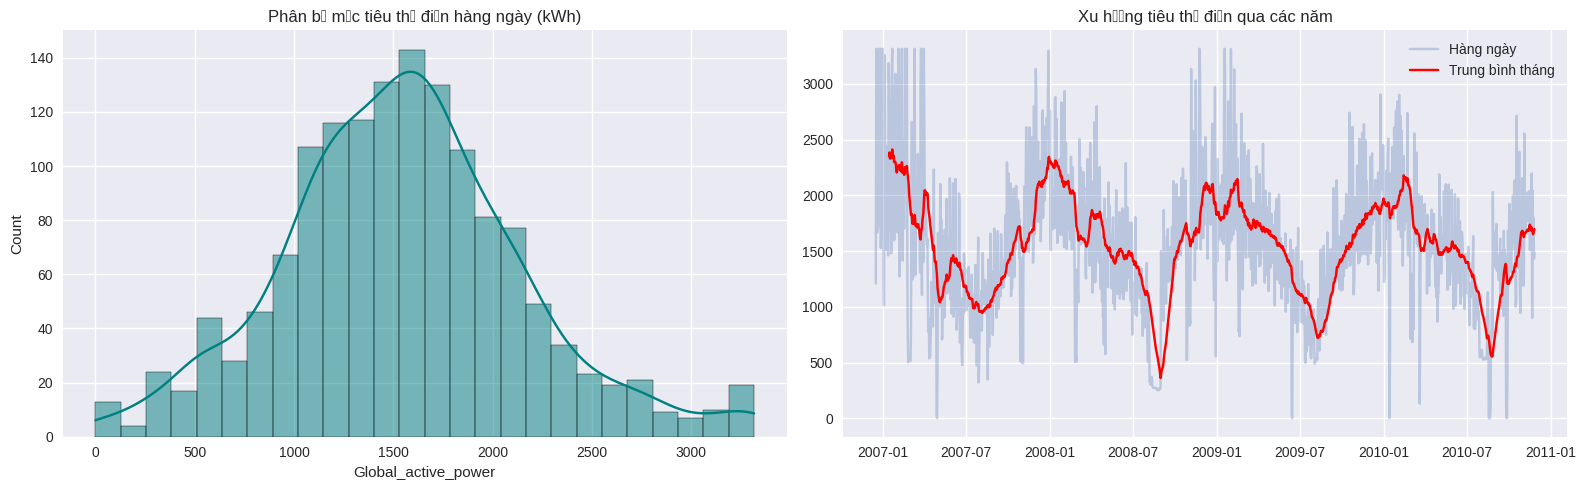

In [250]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Biểu đồ 1: Phân bổ tiêu thụ điện
sns.histplot(df_daily['Global_active_power'], kde=True, ax=axes[0], color='teal')
axes[0].set_title('Phân bổ mức tiêu thụ điện hàng ngày (kWh)')

# Biểu đồ 2: Xu hướng dài hạn (Rolling Mean)
axes[1].plot(df_daily['Global_active_power'], alpha=0.3, label='Hàng ngày')
axes[1].plot(df_daily['Global_active_power'].rolling(30).mean(), color='red', label='Trung bình tháng')
axes[1].set_title('Xu hướng tiêu thụ điện qua các năm')
axes[1].legend()

plt.tight_layout()
plt.show()



---
## **3.FEATURE ENGINEERING (KỸ THUẬT ĐẶC TRƯNG)**

---

3.1 Biến đổi chuỗi thời gian thành bài toán Học máy có giám sát.

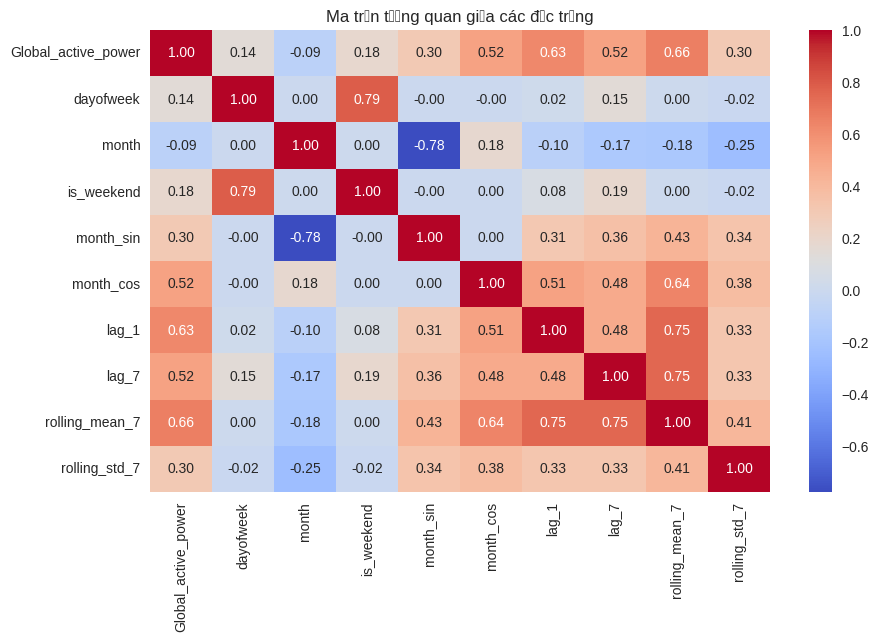

In [251]:
def create_advanced_features(df):
    df = df.copy()
    # Đặc trưng thời gian
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

    # Mã hóa chu kỳ (Cyclical Encoding)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Đặc trưng lịch sử (Lags) - Quan trọng nhất trong học có giám sát
    df['lag_1'] = df['Global_active_power'].shift(1)
    df['lag_7'] = df['Global_active_power'].shift(7)

    # Đặc trưng cửa sổ trượt (Rolling)
    df['rolling_mean_7'] = df['Global_active_power'].rolling(window=7).mean().shift(1)
    df['rolling_std_7'] = df['Global_active_power'].rolling(window=7).std().shift(1)

    return df.dropna()

data = create_advanced_features(df_daily)

# Vẽ ma trận tương quan để xem biến nào ảnh hưởng nhất
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Ma trận tương quan giữa các đặc trưng')
plt.show()

## **4. HUẤN LUYỆN VÀ DỰ BÁO CUỐN CHIẾU (RECURSIVE FORECASTING)**

---
4.1. Chia dữ liệu và Chuẩn hóa

---




In [252]:
data = create_advanced_features(df_daily)
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]

X_train = train_data.drop('Global_active_power', axis=1)
y_train = train_data['Global_active_power']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)



---

4.2. Workflow Dự báo cuốn chiếu

---



In [253]:
import numpy as np
import pandas as pd

def recursive_forecast(model, scaler, history_df, steps=30):
    """
    Dự báo cuốn chiếu 30 ngày
    """
    current_history = history_df.copy()
    forecasts = []

    for _ in range(steps):
        # 1. Tạo feature từ dữ liệu lịch sử hiện tại
        features = create_advanced_features(current_history)
        X_next = features.iloc[-1:].drop('Global_active_power', axis=1)

        # 2. Chuẩn hóa và dự báo
        X_next_scaled = scaler.transform(X_next)
        y_pred = model.predict(X_next_scaled)[0]

        # Đảm bảo kết quả không âm
        y_pred = max(0, y_pred)
        forecasts.append(y_pred)

        # 3. Cập nhật lịch sử: Thêm dòng dự báo mới vào để tính feature cho ngày kế tiếp
        next_date = current_history.index[-1] + pd.Timedelta(days=1)
        new_row = pd.DataFrame({'Global_active_power': [y_pred]}, index=[next_date])
        current_history = pd.concat([current_history, new_row])

    return np.array(forecasts) # Trả về Numpy Array để tránh lỗi .sum()

## **5. THỰC NGHIỆM VÀ TỐI ƯU TỪNG MÔ HÌNH**

---

5.1. Hàm đánh giá mô hình trên Recursive Forecast

---



In [254]:
def evaluate_recursive_forecast(model, scaler, df_daily, train_size, forecast_horizon=30):
    """
    Hàm mục tiêu để Optuna tối ưu (Tính sai số tổng hóa đơn)
    """
    # Lấy 35 ngày trước tập test để làm đặc trưng (lag)
    history_df = df_daily.iloc[train_size - 35 : train_size]

    # Giá trị thực tế 30 ngày
    actual = df_daily.iloc[train_size : train_size + forecast_horizon]['Global_active_power']

    # Dự báo cuốn chiếu
    predictions = recursive_forecast(model, scaler, history_df, steps=forecast_horizon)

    # Đảm bảo predictions là numpy array
    predictions = np.array(predictions)

    # Tính sai số tổng hóa đơn (%)
    actual_sum = actual.sum()
    if actual_sum == 0: return 100.0 # Tránh lỗi chia cho 0

    total_error_pct = abs(actual_sum - predictions.sum()) / actual_sum * 100

    return total_error_pct



---



5.2 TỐI ƯU LINEAR REGRESSION

---



In [255]:
def optimize_linear_regression(df_daily, train_size, n_trials=30):
    """
    Tối ưu Linear Regression với regularization

    Tham số tối ưu:
    - type: 'none' (OLS), 'ridge' (L2), 'lasso' (L1)
    - alpha: Hệ số regularization (nếu dùng Ridge/Lasso)
    """
    print("\n" + "="*70)
    print("PHẦN 2.1: TỐI ƯU LINEAR REGRESSION")
    print("="*70)

    # Chuẩn bị dữ liệu
    data = create_advanced_features(df_daily)
    train_data = data.iloc[:train_size]
    X_train = train_data.drop('Global_active_power', axis=1)
    y_train = train_data['Global_active_power']
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    def objective(trial):
        # Chọn loại model
        reg_type = trial.suggest_categorical('type', ['ridge', 'lasso', 'none'])

        if reg_type == 'ridge':
            alpha = trial.suggest_float('alpha', 0.001, 100, log=True)
            model = Ridge(alpha=alpha)
        elif reg_type == 'lasso':
            alpha = trial.suggest_float('alpha', 0.001, 100, log=True)
            model = Lasso(alpha=alpha, max_iter=5000)
        else:
            model = LinearRegression()

        # Train
        model.fit(X_train_scaled, y_train)

        # Đánh giá
        error = evaluate_recursive_forecast(model, scaler, df_daily, train_size)
        return error

    # Tối ưu với Optuna
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # In kết quả
    print(f"\n✓ Hoàn thành tối ưu Linear Regression")
    print(f"Best Total Error: {study.best_value:.3f}%")
    print(f"Best params: {study.best_params}")

    return study



---


5.3 TỐI ƯU RANDOM FOREST

---



In [256]:
def optimize_random_forest(df_daily, train_size, n_trials=100):
    """
    Tối ưu Random Forest với Optuna

    Search space:
    - n_estimators: [50, 300] - Số cây trong rừng
    - max_depth: [2, 10] - Độ sâu cây (quan trọng cho recursive forecast)
    - min_samples_split: [2, 20] - Số samples tối thiểu để split
    - min_samples_leaf: [1, 10] - Số samples tối thiểu ở lá
    - max_features: ['sqrt', 'log2', None] - Số features mỗi split
    """
    print("\n" + "="*70)
    print("PHẦN 2.2: TỐI ƯU RANDOM FOREST")
    print("="*70)

    # Chuẩn bị dữ liệu
    data = create_advanced_features(df_daily)
    train_data = data.iloc[:train_size]
    X_train = train_data.drop('Global_active_power', axis=1)
    y_train = train_data['Global_active_power']
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'random_state': 42
        }

        model = RandomForestRegressor(**params)
        model.fit(X_train_scaled, y_train)
        error = evaluate_recursive_forecast(model, scaler, df_daily, train_size)

        return error

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\n✓ Hoàn thành tối ưu Random Forest")
    print(f"Best Total Error: {study.best_value:.3f}%")
    print(f"Best params: {study.best_params}")

    return study




---


5.4 TỐI ƯU GRADIENT BOOSTING

---



In [257]:
def optimize_gradient_boosting(df_daily, train_size, n_trials=100):
    """
    Tối ưu Gradient Boosting với Optuna

    Search space:
    - n_estimators: [50, 400]
    - learning_rate: [0.001, 0.05] - LOG SCALE (quan trọng!)
    - max_depth: [2, 6] - Cây nông hơn RF
    - subsample: [0.6, 1.0] - Regularization
    - min_samples_split/leaf: Kiểm soát overfitting
    """
    print("\n" + "="*70)
    print("PHẦN 2.3: TỐI ƯU GRADIENT BOOSTING")
    print("="*70)

    # Chuẩn bị dữ liệu
    data = create_advanced_features(df_daily)
    train_data = data.iloc[:train_size]
    X_train = train_data.drop('Global_active_power', axis=1)
    y_train = train_data['Global_active_power']
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 400),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 6),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'random_state': 42
        }

        model = GradientBoostingRegressor(**params)
        model.fit(X_train_scaled, y_train)
        error = evaluate_recursive_forecast(model, scaler, df_daily, train_size)

        return error

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\n✓ Hoàn thành tối ưu Gradient Boosting")
    print(f"Best Total Error: {study.best_value:.3f}%")
    print(f"Best params: {study.best_params}")

    return study



---


5.5 TỐI ƯU XGBOOST

---



In [258]:
def optimize_xgboost(df_daily, train_size, n_trials=100):
    """
    Tối ưu XGBoost với Optuna

    Search space (rộng hơn GB):
    - n_estimators: [50, 400]
    - learning_rate: [0.001, 0.05] - LOG SCALE
    - max_depth: [2, 8] - Sâu hơn GB một chút
    - subsample: [0.6, 1.0]
    - colsample_bytree: [0.6, 1.0] - Unique cho XGBoost
    - min_child_weight: [1, 10]
    - gamma: [0, 0.5] - Minimum loss reduction
    - reg_alpha, reg_lambda: [0, 1] - L1/L2 regularization
    """
    print("\n" + "="*70)
    print("PHẦN 2.4: TỐI ƯU XGBOOST")
    print("="*70)

    # Chuẩn bị dữ liệu
    data = create_advanced_features(df_daily)
    train_data = data.iloc[:train_size]
    X_train = train_data.drop('Global_active_power', axis=1)
    y_train = train_data['Global_active_power']
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 400),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 8),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 0.5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
            'random_state': 42
        }

        model = xgb.XGBRegressor(**params)
        model.fit(X_train_scaled, y_train)
        error = evaluate_recursive_forecast(model, scaler, df_daily, train_size)

        return error

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"\n✓ Hoàn thành tối ưu XGBoost")
    print(f"Best Total Error: {study.best_value:.3f}%")
    print(f"Best params: {study.best_params}")

    return study

## **6. SO SÁNH VÀ ĐÁNH GIÁ KẾT QUẢ**

---

6.1. Thực hiện tối ưu các mô hình và so sánh
---



In [259]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def compare_optimized_models(studies_dict, df_daily, train_size):
    print("\n" + "="*80)
    print("BẮT ĐẦU SO SÁNH CÁC MÔ HÌNH SAU KHI TỐI ƯU")
    print("="*80)

    # Chuẩn bị dữ liệu huấn luyện
    data = create_advanced_features(df_daily)
    train_data = data.iloc[:train_size]
    X_train = train_data.drop('Global_active_power', axis=1)
    y_train = train_data['Global_active_power']

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    history_df = df_daily.iloc[train_size - 35 : train_size]
    actual_30d = df_daily.iloc[train_size : train_size + 30]['Global_active_power']

    results = {}
    models_trained = {}

    for name, study in studies_dict.items():
        print(f"\n[+] Đang huấn luyện lại {name}...")
        bp = study.best_params

        # Khởi tạo model với best_params
        if name == 'Linear Regression':
            model = Ridge(alpha=bp['alpha']) if bp.get('type') == 'ridge' else \
                    Lasso(alpha=bp['alpha']) if bp.get('type') == 'lasso' else LinearRegression()
        elif name == 'Random Forest':
            model = RandomForestRegressor(n_estimators=bp['n_estimators'], max_depth=bp['max_depth'], random_state=42)
        elif name == 'Gradient Boosting':
            model = GradientBoostingRegressor(**bp, random_state=42)
        elif name == 'XGBoost':
            import xgboost as xgb
            model = xgb.XGBRegressor(**bp, random_state=42)

        model.fit(X_train_scaled, y_train)
        models_trained[name] = model

        # Dự báo 30 ngày
        preds = recursive_forecast(model, scaler, history_df, steps=30)

        # Tính toán các chỉ số
        rmse = np.sqrt(mean_squared_error(actual_30d, preds))
        mae = mean_absolute_error(actual_30d, preds)
        mape = np.mean(np.abs((actual_30d - preds) / actual_30d)) * 100
        r2 = r2_score(actual_30d, preds)
        total_err = abs(actual_30d.sum() - preds.sum()) / actual_30d.sum() * 100

        results[name] = {
            'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R²': r2,
            'Total_Error_Pct': total_err, 'predictions': preds, 'Forecasts': preds
        }
        print(f"    ✓ Hoàn thành. Sai số tổng: {total_err:.2f}%")

    return results, models_trained, actual_30d

# Call optimization functions to populate studies_dict before using it
# Using fewer trials (n_trials=10) for demonstration purposes to speed up execution.
# In a full run, consider increasing n_trials for better optimization.
print("\n===== BẮT ĐẦU TỐI ƯU CÁC MÔ HÌNH ====")
linear_study = optimize_linear_regression(df_daily, train_size, n_trials=10)
rf_study = optimize_random_forest(df_daily, train_size, n_trials=10)
gb_study = optimize_gradient_boosting(df_daily, train_size, n_trials=10)
xgb_study = optimize_xgboost(df_daily, train_size, n_trials=10)
print("===== HOÀN THÀNH TỐI ƯU CÁC MÔ HÌNH ====")

studies_dict = {
    'Linear Regression': linear_study,
    'Random Forest': rf_study,
    'Gradient Boosting': gb_study,
    'XGBoost': xgb_study
}

results, models_trained, actual_30d = compare_optimized_models(studies_dict, df_daily, train_size)


[I 2026-01-04 11:27:07,528] A new study created in memory with name: no-name-f8bafdb0-c847-4038-a212-4ec1fb7bddc7



===== BẮT ĐẦU TỐI ƯU CÁC MÔ HÌNH ====

PHẦN 2.1: TỐI ƯU LINEAR REGRESSION


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-04 11:27:07,850] Trial 0 finished with value: 20.315023688323315 and parameters: {'type': 'none'}. Best is trial 0 with value: 20.315023688323315.
[I 2026-01-04 11:27:08,049] Trial 1 finished with value: 18.838680050263655 and parameters: {'type': 'lasso', 'alpha': 0.47627866858070417}. Best is trial 1 with value: 18.838680050263655.
[I 2026-01-04 11:27:08,230] Trial 2 finished with value: 20.315023688323315 and parameters: {'type': 'none'}. Best is trial 1 with value: 18.838680050263655.
[I 2026-01-04 11:27:08,489] Trial 3 finished with value: 20.315023688323315 and parameters: {'type': 'none'}. Best is trial 1 with value: 18.838680050263655.
[I 2026-01-04 11:27:08,804] Trial 4 finished with value: 16.906684496349147 and parameters: {'type': 'lasso', 'alpha': 1.1350426511126965}. Best is trial 4 with value: 16.906684496349147.
[I 2026-01-04 11:27:09,154] Trial 5 finished with value: 20.29494978014659 and parameters: {'type': 'ridge', 'alpha': 0.023368191622200336}. Best is 

[I 2026-01-04 11:27:10,858] A new study created in memory with name: no-name-6481ae87-47f3-4775-bd58-27563942de8e


[I 2026-01-04 11:27:10,825] Trial 9 finished with value: 7.2552669782543076 and parameters: {'type': 'ridge', 'alpha': 82.85859511860167}. Best is trial 9 with value: 7.2552669782543076.

✓ Hoàn thành tối ưu Linear Regression
Best Total Error: 7.255%
Best params: {'type': 'ridge', 'alpha': 82.85859511860167}

PHẦN 2.2: TỐI ƯU RANDOM FOREST


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-04 11:27:12,361] Trial 0 finished with value: 11.995277276991786 and parameters: {'n_estimators': 184, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 11.995277276991786.
[I 2026-01-04 11:27:13,289] Trial 1 finished with value: 11.698820314195483 and parameters: {'n_estimators': 53, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 1 with value: 11.698820314195483.
[I 2026-01-04 11:27:15,612] Trial 2 finished with value: 12.51824556959717 and parameters: {'n_estimators': 132, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 11.698820314195483.
[I 2026-01-04 11:27:16,784] Trial 3 finished with value: 13.771115483801333 and parameters: {'n_estimators': 95, 'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 1 with value: 11.698820314195483.
[

[I 2026-01-04 11:27:23,928] A new study created in memory with name: no-name-bdac7d2a-cf8d-4c3d-9ca2-d0313d8c4ac6


[I 2026-01-04 11:27:23,914] Trial 9 finished with value: 14.05568850564097 and parameters: {'n_estimators': 191, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 1 with value: 11.698820314195483.

✓ Hoàn thành tối ưu Random Forest
Best Total Error: 11.699%
Best params: {'n_estimators': 53, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None}

PHẦN 2.3: TỐI ƯU GRADIENT BOOSTING


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-04 11:27:24,918] Trial 0 finished with value: 4.20407777539974 and parameters: {'n_estimators': 279, 'learning_rate': 0.005557497604112873, 'max_depth': 6, 'subsample': 0.6536559943061623, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 0 with value: 4.20407777539974.
[I 2026-01-04 11:27:25,544] Trial 1 finished with value: 9.125054154554348 and parameters: {'n_estimators': 112, 'learning_rate': 0.04602742318117464, 'max_depth': 4, 'subsample': 0.9132254813167552, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 0 with value: 4.20407777539974.
[I 2026-01-04 11:27:26,623] Trial 2 finished with value: 1.0012096451603036 and parameters: {'n_estimators': 277, 'learning_rate': 0.002922413116610358, 'max_depth': 4, 'subsample': 0.747801306740232, 'min_samples_split': 12, 'min_samples_leaf': 7}. Best is trial 2 with value: 1.0012096451603036.
[I 2026-01-04 11:27:27,964] Trial 3 finished with value: 10.284621108144565 and parameters: {'n_estimators': 354,

[I 2026-01-04 11:27:32,703] A new study created in memory with name: no-name-83fe3835-2668-401c-8a58-52d6ef92910b


[I 2026-01-04 11:27:32,688] Trial 9 finished with value: 3.7011457558313317 and parameters: {'n_estimators': 300, 'learning_rate': 0.004111542202502739, 'max_depth': 6, 'subsample': 0.7020703712264598, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 2 with value: 1.0012096451603036.

✓ Hoàn thành tối ưu Gradient Boosting
Best Total Error: 1.001%
Best params: {'n_estimators': 277, 'learning_rate': 0.002922413116610358, 'max_depth': 4, 'subsample': 0.747801306740232, 'min_samples_split': 12, 'min_samples_leaf': 7}

PHẦN 2.4: TỐI ƯU XGBOOST


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-01-04 11:27:32,958] Trial 0 finished with value: 1.9410993510943357 and parameters: {'n_estimators': 108, 'learning_rate': 0.005018019051823297, 'max_depth': 3, 'subsample': 0.7009353228152168, 'colsample_bytree': 0.8691235912199442, 'min_child_weight': 10, 'gamma': 0.09885834150591488, 'reg_alpha': 0.5019490912268549, 'reg_lambda': 0.3011034170470459}. Best is trial 0 with value: 1.9410993510943357.
[I 2026-01-04 11:27:33,229] Trial 1 finished with value: 11.637618116320484 and parameters: {'n_estimators': 168, 'learning_rate': 0.026292742608006396, 'max_depth': 4, 'subsample': 0.7576428113069206, 'colsample_bytree': 0.7566737476390102, 'min_child_weight': 9, 'gamma': 0.49661552597533765, 'reg_alpha': 0.309452918415716, 'reg_lambda': 0.8742697513452973}. Best is trial 0 with value: 1.9410993510943357.
[I 2026-01-04 11:27:33,665] Trial 2 finished with value: 6.354121703699868 and parameters: {'n_estimators': 213, 'learning_rate': 0.010580891815612984, 'max_depth': 8, 'subsample



---
6.2. In bảng tổng hợp kết quả chi tiết
---




In [260]:
def print_detailed_results(results, studies_dict):
    """
    In bảng tổng hợp kết quả chi tiết

    → Đưa vào phần "Bảng kết quả" của báo cáo
    """
    print("\n" + "="*80)
    print(" "*20 + "BẢNG TỔNG HỢP KẾT QUẢ")
    print("="*80)

    # Tạo DataFrame tổng hợp
    summary_data = []
    for name, data in results.items():
        summary_data.append({
            'Mô hình': name,
            'RMSE (kWh)': f"{data['RMSE']:.2f}",
            'MAE (kWh)': f"{data['MAE']:.2f}",
            'MAPE (%)': f"{data['MAPE']:.2f}",
            'R²': f"{data['R²']:.4f}",
            'Sai số tổng (%)': f"{data['Total_Error_Pct']:.2f}"
        })

    df_summary = pd.DataFrame(summary_data).sort_values('Sai số tổng (%)')
    print("\n" + df_summary.to_string(index=False))

    # In tham số tối ưu
    print("\n" + "="*80)
    print("THAM SỐ TỐI ƯU CHO TỪNG MÔ HÌNH:")
    print("="*80)

    for name, study in studies_dict.items():
        print(f"\n【{name}】")
        print("-" * 60)
        for key, value in study.best_params.items():
            if isinstance(value, float):
                print(f"  {key:25s}: {value:.6f}")
            else:
                print(f"  {key:25s}: {value}")
        print(f"  {'→ Total Error':25s}: {study.best_value:.3f}%")

    # Xác định winner
    best_model = df_summary.iloc[0]['Mô hình']
    best_error = float(df_summary.iloc[0]['Sai số tổng (%)'].replace('%', ''))

    print("\n" + "="*80)
    print(f"🏆 MÔ HÌNH TỐT NHẤT: {best_model}")
    print(f"   Sai số hóa đơn tháng: {best_error:.2f}%")
    print("="*80)

print_detailed_results(results, studies_dict)


                    BẢNG TỔNG HỢP KẾT QUẢ

          Mô hình RMSE (kWh) MAE (kWh) MAPE (%)     R² Sai số tổng (%)
Gradient Boosting     544.74    461.91    35.95 0.0844            1.00
          XGBoost     544.38    461.29    34.88 0.0856            1.94
Linear Regression     546.86    443.52    36.62 0.0773            7.26
    Random Forest     523.07    438.76    35.43 0.1558            9.01

THAM SỐ TỐI ƯU CHO TỪNG MÔ HÌNH:

【Linear Regression】
------------------------------------------------------------
  type                     : ridge
  alpha                    : 82.858595
  → Total Error            : 7.255%

【Random Forest】
------------------------------------------------------------
  n_estimators             : 53
  max_depth                : 8
  min_samples_split        : 5
  min_samples_leaf         : 2
  max_features             : None
  → Total Error            : 11.699%

【Gradient Boosting】
------------------------------------------------------------
  n_estimators     



---

6.3 Tạo các biểu đồ so sánh

---



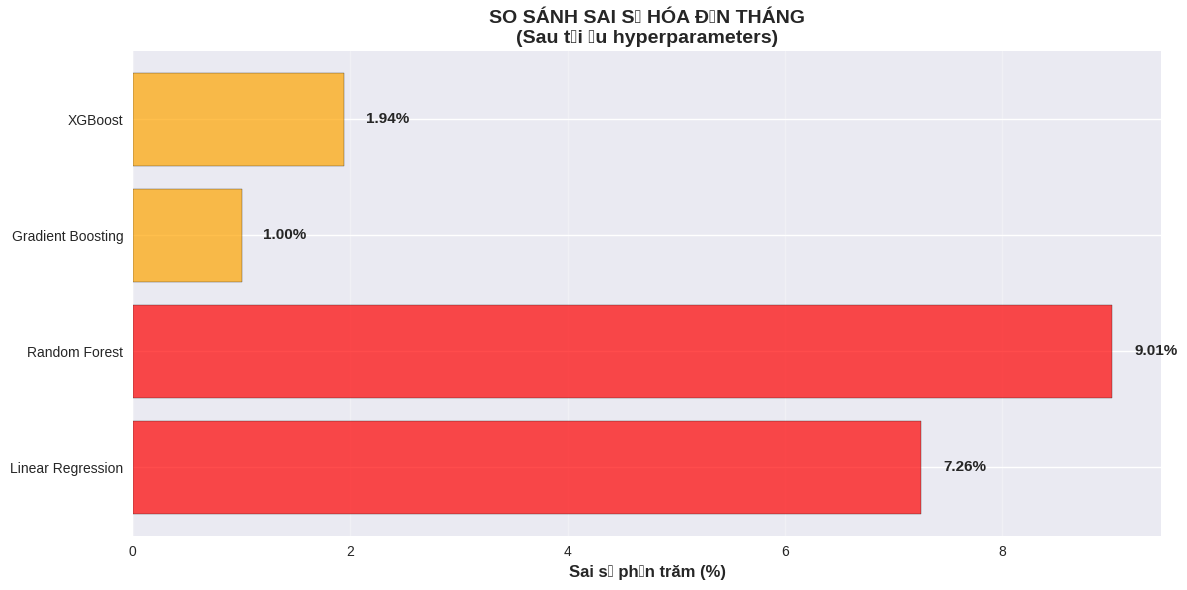

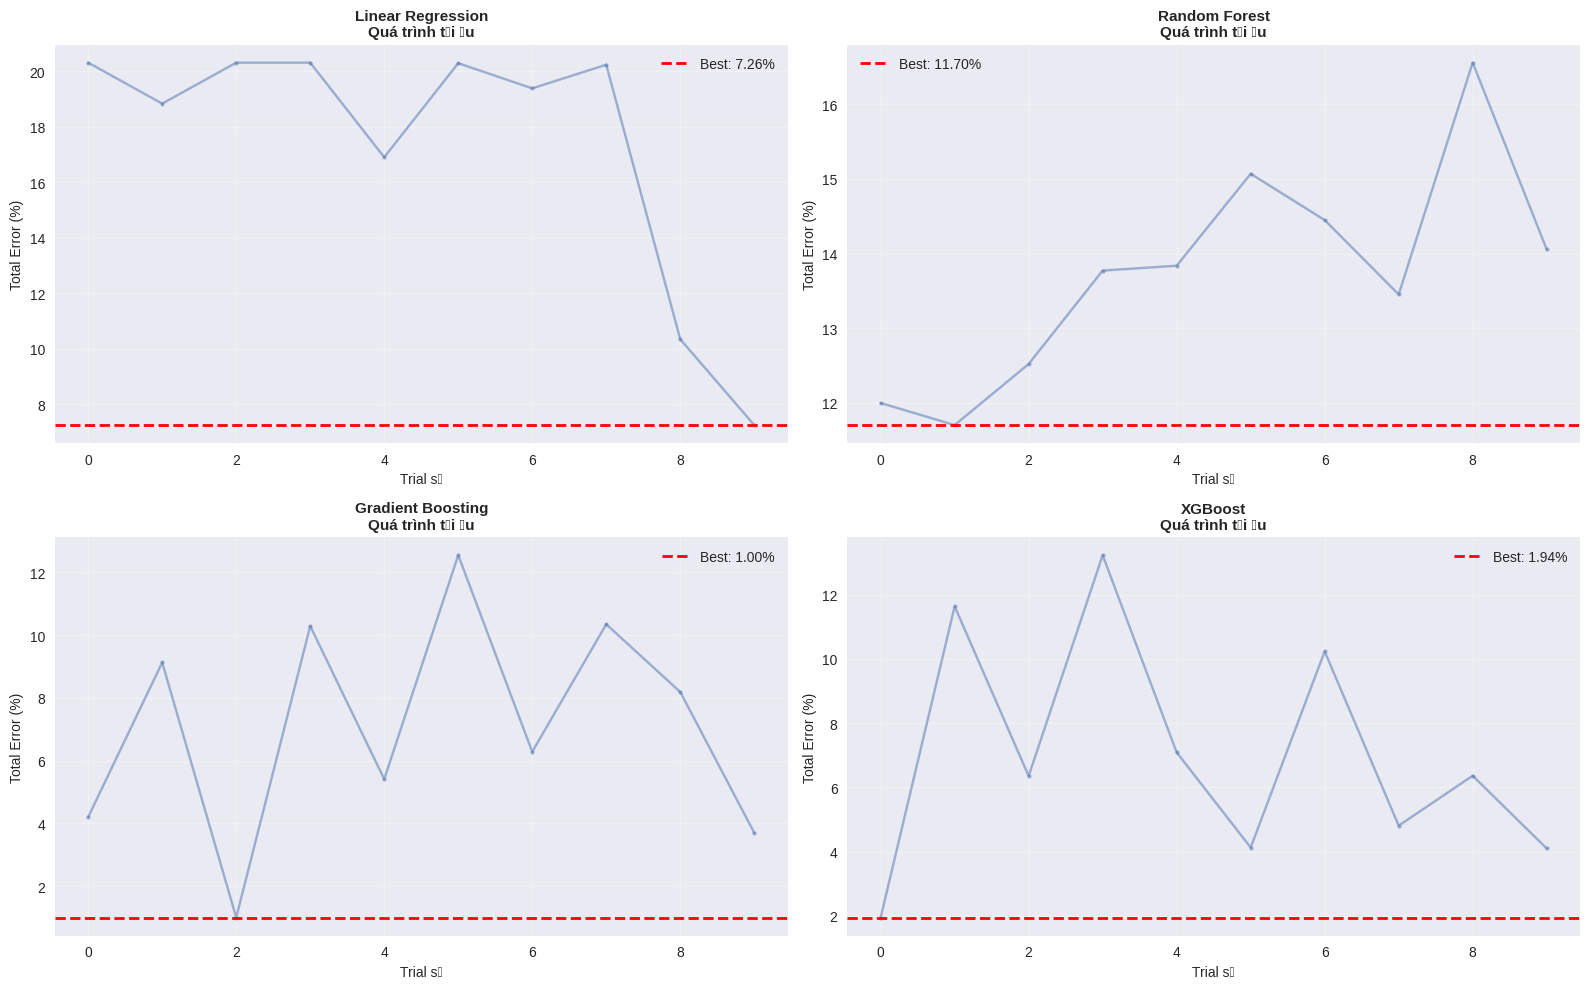

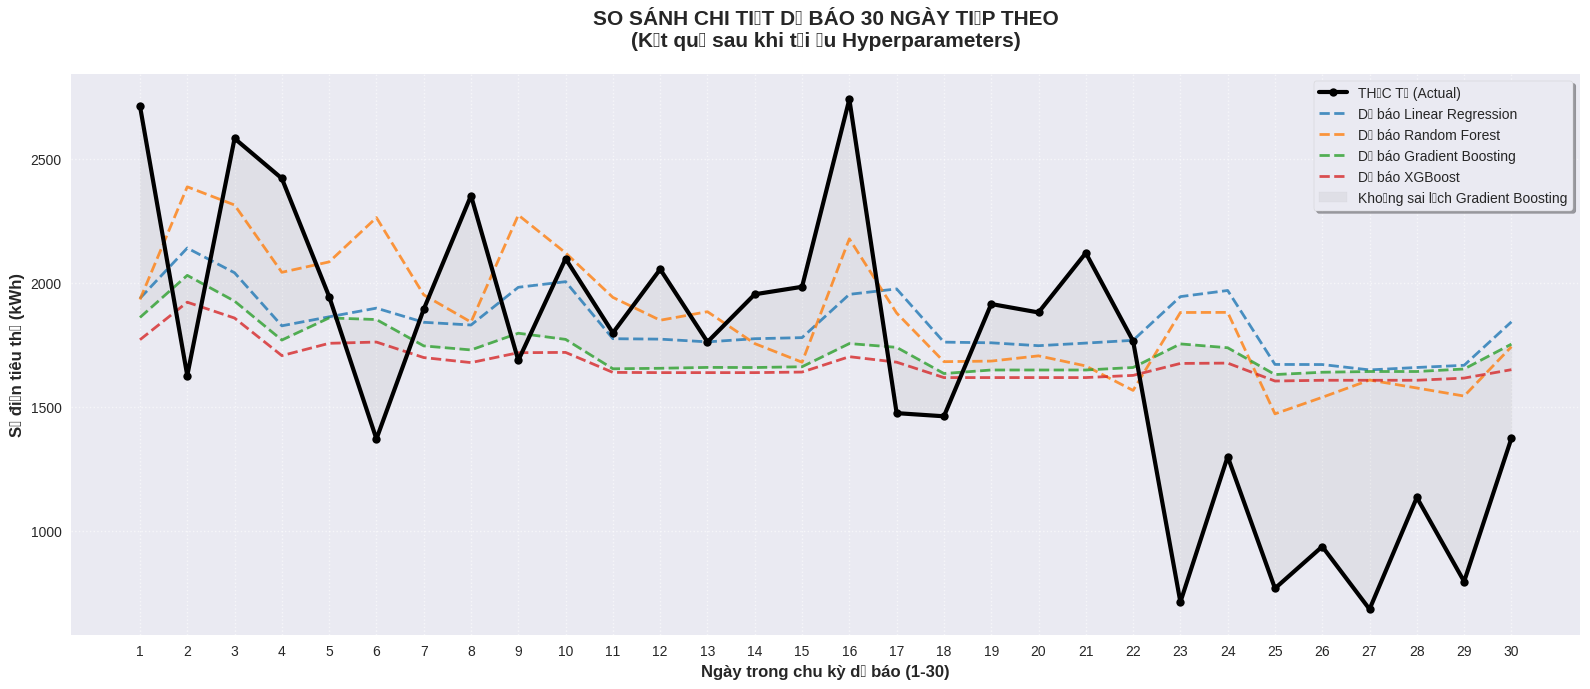

In [261]:
def visualize_comparison(results, actual_30d):
    """Biểu đồ so sánh Total Error"""

    fig, ax = plt.subplots(figsize=(12, 6))

    names = list(results.keys())
    errors = [results[name]['Total_Error_Pct'] for name in names]
    colors = ['green' if e < 1 else 'orange' if e < 5 else 'red' for e in errors]

    bars = ax.barh(names, errors, color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel('Sai số phần trăm (%)', fontsize=12, fontweight='bold')
    ax.set_title('SO SÁNH SAI SỐ HÓA ĐƠN THÁNG\n(Sau tối ưu hyperparameters)',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

    # Thêm giá trị
    for bar, error in zip(bars, errors):
        ax.text(error + 0.2, bar.get_y() + bar.get_height()/2,
                f'{error:.2f}%', va='center', fontweight='bold', fontsize=11)

    plt.tight_layout()
    plt.show()

def visualize_optimization_history(studies_dict):
    """Biểu đồ optimization history cho từng mô hình"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    for idx, (name, study) in enumerate(studies_dict.items()):
        trials_df = study.trials_dataframe()

        axes[idx].plot(trials_df['number'], trials_df['value'],
                      'o-', alpha=0.5, markersize=3)
        axes[idx].axhline(study.best_value, color='red', linestyle='--',
                         linewidth=2, label=f'Best: {study.best_value:.2f}%')
        axes[idx].set_xlabel('Trial số', fontsize=10)
        axes[idx].set_ylabel('Total Error (%)', fontsize=10)
        axes[idx].set_title(f'{name}\nQuá trình tối ưu', fontsize=11, fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_forecasts(results, actual_30d):
    """
    Biểu đồ dự báo chi tiết 30 ngày: Thực tế vs Các mô hình tối ưu
    """
    fig, ax = plt.subplots(figsize=(16, 7))

    # 1. Vẽ dữ liệu thực tế (Làm nổi bật bằng màu đen và điểm tròn)
    days = np.arange(1, 31)
    ax.plot(days, actual_30d.values, 'o-', color='black', linewidth=3,
            label='THỰC TẾ (Actual)', markersize=6, zorder=5)

    # 2. Vẽ đường dự báo cho từng mô hình trong results
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Màu sắc đặc trưng cho 4 mô hình
    linestyles = ['--', '--', '--', '--']

    for idx, (name, data) in enumerate(results.items()):
        # Lấy mảng dự báo từ dictionary kết quả
        preds = data['Forecasts']
        ax.plot(days, preds, linestyle=linestyles[idx], color=colors[idx],
                linewidth=2, label=f'Dự báo {name}', alpha=0.8)

    # 3. Trang trí biểu đồ chuyên nghiệp
    ax.set_title('SO SÁNH CHI TIẾT DỰ BÁO 30 NGÀY TIẾP THEO\n(Kết quả sau khi tối ưu Hyperparameters)',
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xlabel('Ngày trong chu kỳ dự báo (1-30)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Số điện tiêu thụ (kWh)', fontsize=12, fontweight='bold')

    # Cấu hình trục X hiển thị đủ 30 ngày
    ax.set_xticks(days)
    ax.grid(True, linestyle=':', alpha=0.6)

    # Thêm vùng bóng đổ cho mô hình tốt nhất (giả sử là Random Forest hoặc XGBoost)
    # Tìm mô hình có sai số thấp nhất để highlight
    best_model = min(results, key=lambda x: results[x]['Total_Error_Pct'])
    ax.fill_between(days, actual_30d.values, results[best_model]['Forecasts'],
                    color='gray', alpha=0.1, label=f'Khoảng sai lệch {best_model}')

    ax.legend(loc='upper right', frameon=True, shadow=True, fontsize=10)

    plt.tight_layout()
    plt.show()
    # Call visualization functions
visualize_comparison(results, actual_30d)
visualize_optimization_history(studies_dict)
visualize_forecasts(results, actual_30d)